In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [17]:
dataroot = '/content/image/'  #  데이터세트 폴더의 루트 경로
workers = 2   # Dataloader를 이용해 데이터를 로드하기 위해 사용되는 스레드 수
batch_size = 128  # 학습에서 사용되는 배치 크기. 논문에서는 128.
image_size = 256  # 학습에서 사용되는 이미지 크기. (모든 이미지가 이 사이즈에 맞게 resize 된다.) 디폴트 값은 64
nc = 3  # 인풋 이미지의 색상 채널 수. 컬러 이미지는 이 값이 3이다. (*흑백 이미지의 경우 1)
nz = 100  # 잠재 벡터의 길이(크기)
ngf = 256  #Generator를 거치는 피쳐 맵의 크기
ndf = 256  #Discriminator를 거치는 피쳐 맵의 크기
num_epochs = 30  # training epoch의 수. 오랜 시간 학습하는 것이 더 좋은 결과를 낳지만, 더 오랜 시간이 걸릴 수 있다.
lr = 0.0002  #학습에서 사용되는 learning rate. 논문에서는 0.0002
beta1 = 0.5  #Adam optimizer를 위한 하이퍼파라미터이다. 논문에서는 0.5
ngpu = 1 #가능한 gpu의 수. 이 값이 0이라면 CPU 모드에서 작동할 것이다. 0보다 더 큰 수일 경우, 숫자만큼의 GPU에서 작동할 것이다

In [18]:
!git clone https://github.com/ahnje/image.git 

fatal: destination path 'image' already exists and is not an empty directory.


In [19]:
!ls

drive  image  sample_data


In [20]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

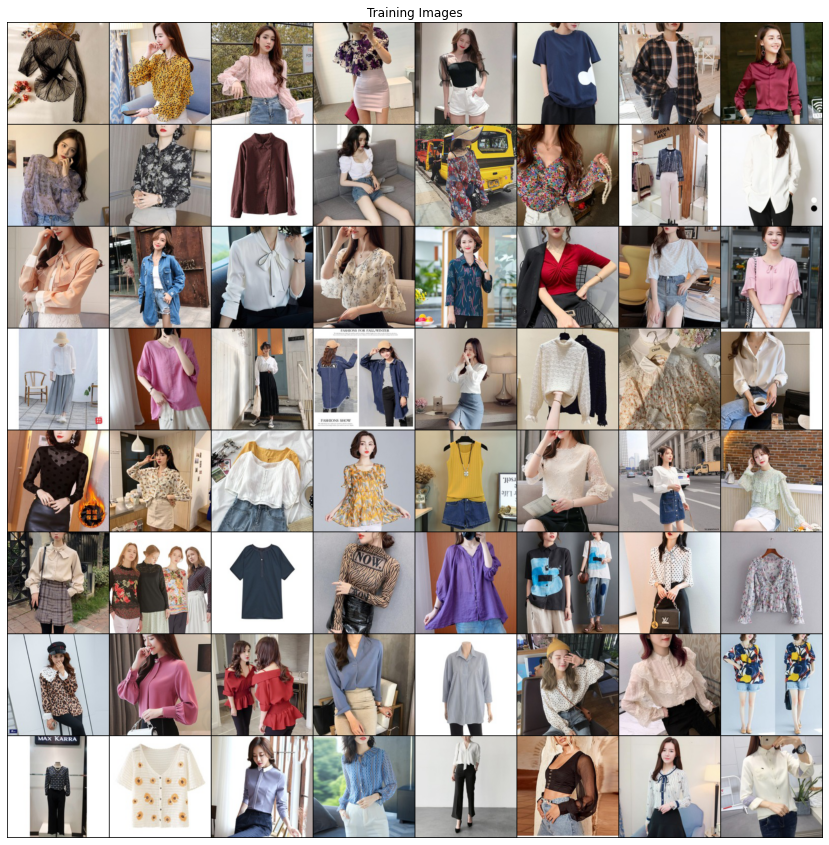

In [21]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [22]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
""" nn.ConvTranspose2d(nz, ngf * 16, 4, stride = 2, padding = 1, bias=False),
            # input , output , kernel , stride  ,padding 
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4

            nn.ConvTranspose2d(ngf * 16, ngf * 16, 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 8 x 8

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4,  stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 16 x 16 
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4,  stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 32 x 32

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4,  stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf * 2) x 64 x 64

            nn.ConvTranspose2d(ngf * 2, ngf, 4,  stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 128 x 128

            nn.ConvTranspose2d( ngf, nc, 4,  stride = 2, padding = 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 256 x 256 """

In [79]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

           
             # input is Z, going into a convolution

            nn.ConvTranspose2d(nz, ngf * 16, 4, stride = 2, padding = 1, bias=False),
            # input , output , kernel , stride  ,padding 
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4

            nn.ConvTranspose2d(ngf * 16, ngf * 16, 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 8 x 8

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4,  stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 16 x 16 
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4,  stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 32 x 32

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4,  stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf * 2) x 64 x 64

            nn.ConvTranspose2d(ngf * 2, ngf, 4,  stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 128 x 128

            nn.ConvTranspose2d( ngf, nc, 4,  stride = 2, padding = 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 256 x 256
        )

    def forward(self, input):
        return self.main(input)

# in_channels(int) : input image의 channel수 이다. rgb이미지라면 3이 되겠다. 
# out_channels(int) : convolution에 의해서 생성된 channel의 수 이다. 
# kernel_size(int or tuple) : convoling_kenel 의 크기이다. 보통은 filter라고 부르는 것과 동일하다.  
# stride(int or tuple) : convolution의 stride를 얼만큼 줄 것이가 이다. Default는 1이다.
# padding(int or tuple) : zero padding을 input의 양쪽에 인자 만큼 해준다. Default는 0이라서 기본적으로 설정해주지 않으면 zero padding은 하지 않는다.

In [80]:
netG = Generator(ngpu).to('cuda:0') 
if (device.type=='cuda') and (ngpu>1): 
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init) 
print(netG)
# netG.to("cuda:0")

RuntimeError: ignored

In [47]:
for name, param in netG.state_dict().items():
  print("Param shape: ", param.shape)

Param shape:  torch.Size([100, 2048, 4, 4])
Param shape:  torch.Size([2048])
Param shape:  torch.Size([2048])
Param shape:  torch.Size([2048])
Param shape:  torch.Size([2048])
Param shape:  torch.Size([])
Param shape:  torch.Size([2048, 1024, 4, 4])
Param shape:  torch.Size([1024])
Param shape:  torch.Size([1024])
Param shape:  torch.Size([1024])
Param shape:  torch.Size([1024])
Param shape:  torch.Size([])
Param shape:  torch.Size([1024, 512, 4, 4])
Param shape:  torch.Size([512])
Param shape:  torch.Size([512])
Param shape:  torch.Size([512])
Param shape:  torch.Size([512])
Param shape:  torch.Size([])
Param shape:  torch.Size([512, 256, 4, 4])
Param shape:  torch.Size([256])
Param shape:  torch.Size([256])
Param shape:  torch.Size([256])
Param shape:  torch.Size([256])
Param shape:  torch.Size([])
Param shape:  torch.Size([256, 3, 4, 4])


In [54]:
import torchsummary

torchsummary.summary(netG, (3, 256,256),device='cuda')

RuntimeError: ignored

In [57]:
class Discriminator(nn.Module): 
    def __init__(self,ngpu): 
        super(Discriminator, self).__init__() 
        self.ngpu = ngpu 
        self.main = nn.Sequential( 
            # input is (nc) x 256 x 256  ==> 3 x 256 x 256 
            nn.Conv2d(nc, ndf, kernel_size = 4, stride=2, padding=1, bias=False), 
# nc : 채널수 ,  ndf : discriminator 피쳐 맵의 크기 , 4 : kernel , 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 128 x 128 == > 256 x 128 x 128

            nn.Conv2d(ndf, ndf * 2, kernel_size = 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32   => 512 x 64 x  64 

            nn.Conv2d(ndf * 2, ndf * 4, kernel_size = 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16    ==> 1024 x 32 x 32 

            nn.Conv2d(ndf * 4, ndf * 8, kernel_size = 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8  ==> 2048  x  16 x 16

            nn.Conv2d(ndf * 8, ndf * 16, kernel_size = 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4  ===> 4096  x  8 x 8 

            nn.Conv2d(ndf * 16, 1, kernel_size = 4, stride=2, padding=1, bias=False),
            #   ==>  
            nn.Sigmoid()
            # state size. 1
             ) 
    def forward(self,input): 
        return self.main(input)

# in_channels(int) : input image의 channel수 이다. rgb이미지라면 3이 되겠다. 
# out_channels(int) : convolution에 의해서 생성된 channel의 수 이다. 
# kernel_size(int or tuple) : convoling_kenel 의 크기이다. 보통은 filter라고 부르는 것과 동일하다.  
# stride(int or tuple) : convolution의 stride를 얼만큼 줄 것이가 이다. Default는 1이다.
# padding(int or tuple) : zero padding을 input의 양쪽에 인자 만큼 해준다. Default는 0이라서 기본적으로 설정해주지 않으면 zero padding은 하지 않는다.

In [58]:
netD = Discriminator(ngpu).to('cuda:0')

if (device.type == 'cuda') and (ngpu > 1): 
    netD = nn.DataParallel(netD, list(range(ngpu))) 
    print(net(D))
netD.apply(weights_init) 
print(netD)
# netD.to("cuda:0")

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(2048, 4096, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(4096, e

In [62]:
for name, param in netD.state_dict().items():
  print("Param shape: ", param.shape)

Param shape:  torch.Size([256, 3, 4, 4])
Param shape:  torch.Size([512, 256, 4, 4])
Param shape:  torch.Size([512])
Param shape:  torch.Size([512])
Param shape:  torch.Size([512])
Param shape:  torch.Size([512])
Param shape:  torch.Size([])
Param shape:  torch.Size([1024, 512, 4, 4])
Param shape:  torch.Size([1024])
Param shape:  torch.Size([1024])
Param shape:  torch.Size([1024])
Param shape:  torch.Size([1024])
Param shape:  torch.Size([])
Param shape:  torch.Size([2048, 1024, 4, 4])
Param shape:  torch.Size([2048])
Param shape:  torch.Size([2048])
Param shape:  torch.Size([2048])
Param shape:  torch.Size([2048])
Param shape:  torch.Size([])
Param shape:  torch.Size([4096, 2048, 4, 4])
Param shape:  torch.Size([4096])
Param shape:  torch.Size([4096])
Param shape:  torch.Size([4096])
Param shape:  torch.Size([4096])
Param shape:  torch.Size([])
Param shape:  torch.Size([1, 4096, 4, 4])


In [63]:
import torchsummary

torchsummary.summary(netD, (3, 256, 256),device='cuda')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 128, 128]          12,288
         LeakyReLU-2        [-1, 256, 128, 128]               0
            Conv2d-3          [-1, 512, 64, 64]       2,097,152
       BatchNorm2d-4          [-1, 512, 64, 64]           1,024
         LeakyReLU-5          [-1, 512, 64, 64]               0
            Conv2d-6         [-1, 1024, 32, 32]       8,388,608
       BatchNorm2d-7         [-1, 1024, 32, 32]           2,048
         LeakyReLU-8         [-1, 1024, 32, 32]               0
            Conv2d-9         [-1, 2048, 16, 16]      33,554,432
      BatchNorm2d-10         [-1, 2048, 16, 16]           4,096
        LeakyReLU-11         [-1, 2048, 16, 16]               0
           Conv2d-12           [-1, 4096, 8, 8]     134,217,728
      BatchNorm2d-13           [-1, 4096, 8, 8]           8,192
        LeakyReLU-14           [-1, 409

In [59]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [60]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


ValueError: ignored

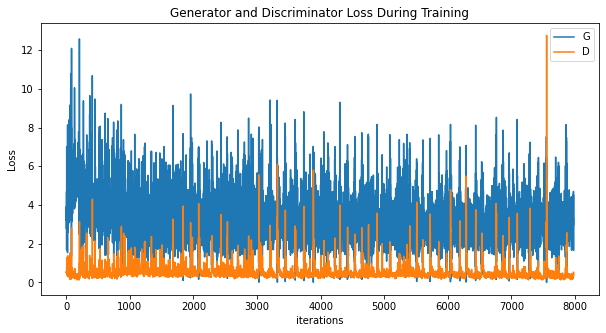

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

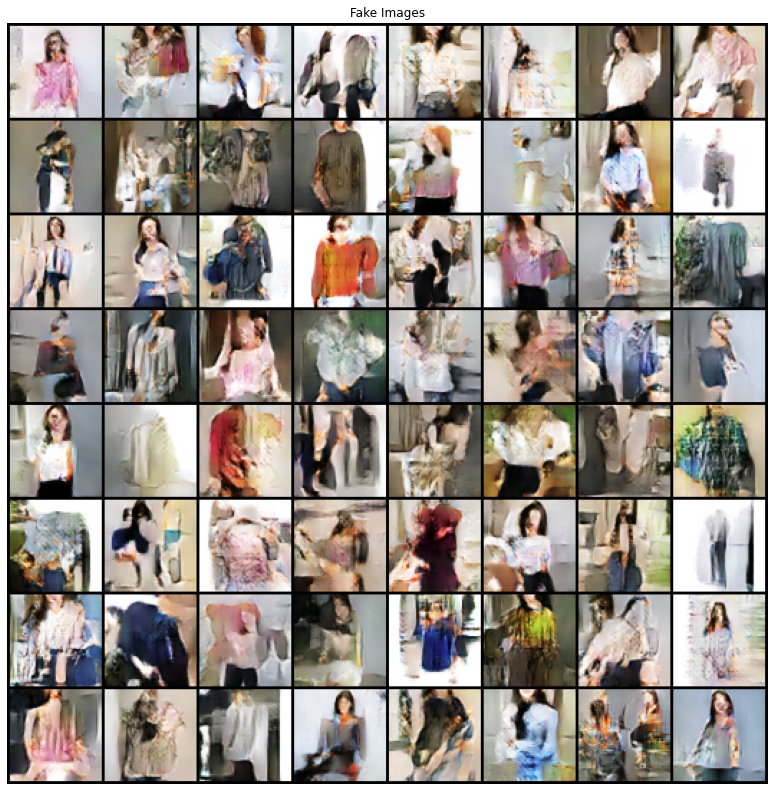

In [33]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(30,30))

# Plot the fake images from the last epoch
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1][:64],(1,2,0)))
plt.show()

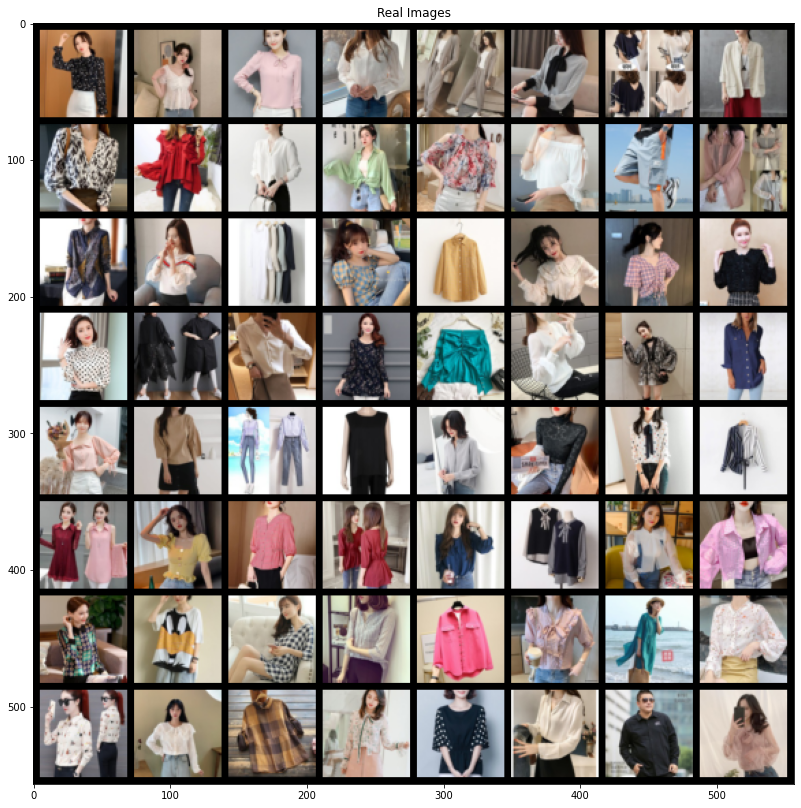

In [24]:
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("on")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

In [ ]:
img_list[0].shape

torch.Size([3, 530, 530])

In [30]:
len(img_list)

17